# Intermediate Machine Learning: Assignment 4

**Deadline**

Assignment 4 is due Monday, November 18 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Graph kernels
 * Reinforcement learning

This assignment will also help to solidify your Python skills.

$\renewcommand{\reals}{{\mathbb R}}
\newcommand{\indp}{\perp\kern-4pt\perp}
\newcommand{\given}{\,|\,}$


## Problem 1: Graph kernels (20 points)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import sklearn
import random
from numpy.linalg import inv
%matplotlib inline

In [3]:
# Helper functions for third part of exercise

def rgb2gray(rgb):
    """Function to turn RGB images in greyscale images."""
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


def grid_adj(rows, cols):
    """Function that creates the adjacency matrix of
    a grid graph with predefined amount of rows and columns."""
    M = np.zeros([rows*cols, rows*cols])
    for r in np.arange(rows):
        for c in np.arange(cols):
            i = r*cols + c
            if c > 0:
                M[i-1, i] = M[i, i-1] = 1
            if r > 0:
                M[i-cols, i] = M[i, i-cols] = 1
    return M

The graph Laplacian for a weighted graph on $n$ nodes is defined as

$$ L = D - W$$

where $W$ is an $n\times n$ symmetric matrix of positive edge weights,
with $W_{ij} = 0$ if $(i,j)$ is not an edge in the graph,
and $D$ is the diagonal matrix with $D_{ii} = \sum_{j=1}^n W_{ij}$.
This generalizes the definition of the Laplacian
used in class, where all of the edge weights are one.


1. Show that $L$ is a Mercer kernel, by showing that $L$ is
  symmetric and positive-semidefinite.
<br>

2. In graph neural networks we define polynomial filters of the form

  $$ P = a_0 I + a_1 L + a_2 L^2 + \cdots a_d L^d$$
  
  where $L$ is the Laplacian and $a_0,\ldots, a_d$ are parameters,
  corresponding to the filter parameters in standard convolutional
  neural networks.

  If each $a_i \geq 0$ is non-negative, show that $P$ is also
  a Mercer kernel.
<br>

3. This polynomial filter has many applications. A handful of these applications
   are based on the fact that, given a graph with a signal x, the value of $x^T L x$
   will be low in case the signal is smooth (i.e. smooth transitions of x between
   neighboring nodes). A large $x^T L x$ means that we have a rough graph signal (i.e.
   a lot of jumps in x between neighboring nodes).
   
   An intersting application that uses this property is the so-called image inpainting
   process, where an image is seen as grid graph. Image inpainting tries to restore
   a corrupted image by smoothing out the neighboring pixel values. In this problem
   we corrupt an image by turning off (i.e. making the pixel value equal to zero) a
   certain portion of the pixels. Your goal will be to restore the corrupted image
   and hence recreate the original image.
   
   First, let's corrupt an image by turning off a portion of the pixels. For this
   exercise, we choose to turn off 30% of the pixels. The result is shown below.
   Try to understand the code, as some variables might be interesting for your work.
   
   The image "Yale_Bulldogs.jpg" can be found in Canvas under assn4 folder, and also in the GitHub repo https://github.com/YData123/sds365-fa24/tree/main/assignments/assn4

In [6]:
# Normalize the pixels of the original image
image = img.imread("/Users/tadcarney/Downloads/Yale_Bulldogs.jpg") / 255
# Turn picture into greyscale
gray_image = rgb2gray(image)
height_img = gray_image.shape[0]
width_img = gray_image.shape[1]

# Turn off (value 0) certain pixels
fraction_off = int(0.30*height_img*width_img)
mask = np.ones(height_img*width_img, dtype=int)
# Set the first fraction of pixels off
mask[:fraction_off] = 0
# Shuffle to create randomness
np.random.shuffle(mask)
# Multiply the original image by the reshapes mask
mask = np.reshape(mask, (height_img, width_img))
corrupted_image = np.multiply(mask, gray_image)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Original Image")
ax2.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Corrupted Image")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tadcarney/Downloads/Yale_Bulldogs.jpg'

Inpainting missing pixel values can be formulated as the following
optimization problem:

$$
\underset{\textbf{x} \in \mathbb{R}^n}{\min} \left\{ \lVert \textbf{y} − \textbf{M} \textbf{x} \rVert^2_2
+ \alpha \textbf{x}^T\textbf{P}\textbf{x} \right\}
$$

where $\textbf{y} \in \mathbb{R}^n$ ($n$ being the total amount of pixels) is the corrupted graph signal
(with missing pixel values being 0) and $\alpha$ is a regularization
(smoothing) parameter that controls for smoothness of the graph. $\textbf{P}$ is the
polynomial filter based on the laplacian $\textbf{L}$. Finally, $\textbf{M}$
$\in \mathbb{R}^{n \times n}$ is a diagonal matrix that satisfies:

$$
\textbf{M}(i, i) =
    \begin{cases}
      1, \ \textrm{if $\textbf{y}$(i) is observed} \\ \\
      0, \ \textrm{if $\textbf{y}$(i) is corrupted}
    \end{cases}\,
$$

The optimization problem tries to find an $\textbf{x}$ that matches the
observed values in $\textbf{y}$, and at the same time tries to be smooth
on the graph. Start with deriving a closed form solution of this optimization
problem:

In [ ]:
# your markdown here

Next, let's restore our image. To keep things simple, let's say we already
trained the polynomial filter $\textbf{P}$ of degree 2 and we found the
following weights:

$$
\textbf{P} =  \textbf{L} + 0.05 \ \textbf{L}^2
$$

Fill in the following lines of code and show your reconstructed images next
to the corrupted image. Assume that the weights on the graph edges are equal to 1.


In [ ]:
# Corrupted graph signal
y =

# Diagonal matrix defined as above
M =

# Adjacency matrix of the graph (by using the helper function)
A =

# Diagonal matrix defined as above
D =

# Graph Laplacian defined as above
L =

# Polynomial filter defined as above
P =

In [ ]:
# closed form solution you derived above
x =

In [ ]:
# Try to experiment with different alpha values
alpha =
reconstructed_image = np.reshape(x, (height_img, width_img))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(corrupted_image, cmap=plt.get_cmap('gray'))
ax1.set_title("Corrupted Image")
ax2.imshow(reconstructed_image, cmap=plt.get_cmap('gray'))
ax2.set_title("Reconstructed Image")

plt.show()

4. Discuss the influence of the smoothing parameter $\alpha$ in
   the optimization problem above. What happens for very large
   and very low values of $\alpha$? Finally, discuss the degree
   of our polynomial function $\textbf{P}$. What happens if
   we would choose a large degree?

In [ ]:
# your markdown and code here


##  Problem 2:  Positive reinforcement  (10 points)
$\def\J{{J}}$
$\def\E{{\mathbb E}}$

As discussed in class, reinforcement learning
using policy gradient methods is based on maximizing the
expected total reward

$$ \J(\theta) = \E_\theta [R(\tau)],$$

where the expectation is over the probability distribution over sequences $\tau$ through a choice of actions using the policy. This can be rewritten as

\begin{align*}
  \nabla_\theta \J(\theta) & = \E_\theta\left[ R(\tau) \nabla_\theta \log p(\tau\given \theta) \right].
\end{align*}

Approximating this gradient involves computing $\nabla_\theta \log \pi_\theta (a \given s)$ where $\pi_\theta$ is the policy.


### 2.1 Continuous action space with Gaussian policy

Suppose that the action space is continuous
and $\pi_\theta(a\given s)$ is a normal density with mean
$\mu_\theta(s)$ and variance $\sigma^2_\theta(s)$, two outputs of
a neural network with input $s$ and parameters $\theta$.


Suppose the outputs of the neural network are given by

\begin{align*}
  \mu_\theta(s) & = \beta_1^T h(s) \\
  \sigma^2_\theta(s) &= \text{exp}(\beta_2^T h(s))
\end{align*}

where $h(s)$ is the vector of neurons in the last layer, immediately
before the outputs. Derive explicit expressions for
$\nabla_{\beta_1} \log \pi_\theta(a\given s)$ and
$\nabla_{\beta_2} \log \pi_\theta(a\given s)$.

Explain how these gradients and other gradient
terms in $\nabla_\theta \log \pi_\theta(a\given s)$ are used
to estimate the policy.



### 2.2 Discrete action space with Softmax policy

Suppose the action space is discrete with K possible actions, and the policy $\pi_\theta(a \mid s)$ is defined using a softmax function over preferences $u_\theta(s,a)$:

$$\pi_\theta(a \mid s) = \frac{\exp(u_\theta(s,a))}{\sum_a \exp(u_\theta(s,a))},$$
where $u_\theta(s,a) = \beta^T h(s,a)$, and $h(s,a)$ is a feature vector for state-action pair $(s,a)$. Derive the expression for $\nabla_\beta \log \pi_\theta(a \mid s)$.

## Problem 3: Deep Q-Learning for Flappy Bird (25 points)

Deep Q-learning was proposed (and patented) by DeepMind and made
a big splash when the same deep neural network architecture was shown to be able to surpass
human performance on many different Atari games, playing directly from the pixels.
In this problem, we will walk you through the implementation of deep Q-learning
to learn to play the Flappy Bird game.

<img src="https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn4/images/flappy_bird_demp.gif" width="144" height="256"/>

The implementation is based these references:
- [DeepLearningFlappyBird](https://github.com/yenchenlin/DeepLearningFlappyBird)
- [Deep Q-Learning for Atari Breakout](https://keras.io/examples/rl/deep_q_network_breakout/)

We use the `pygame` package to visualize the interaction between the algorithm
and the game environment.
However, _pygame_ is not well supported by Google Colab;
we recommend you to run the code for this problem locally.
A window will be popped up that displays
the game as it progress in real-time (as for the Cartpole demo from class).

This problem is structured as follows:

* Load necessary packages
* Test the visualization of the game, to make sure everything's working
* Process the images to reduce the dimension
* Setup the game history buffer
* Implement the core Q-learning function
* Run the learning algorithm
* Interpret the results



### Introduction

The Flappy Bird game is requires a few Python packages. Please install these _as soon as possible_, and notify us of any issues you experience so that we can help. The Python files can also be found on Canvas and in our GitHub repo at https://github.com/YData123/sds365-fa24/tree/main/assignments/assn4 .

In [ ]:
# %pip install pygame
# %pip install opencv-python
import numpy as np
import cv2
import wrapped_flappy_bird as flappy_bird
from collections import deque
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers

pygame 2.1.2 (SDL 2.0.18, Python 3.8.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### The Flappy Bird environment

Interaction with the game environment is carried out through calls of the form

`(image, reward, terminal) = game.frame_step(action)`

where the meaning of these variables is as follows:

- `action`: $\binom{1}{0}$ for doing nothing, $\binom{0}{1}$ for "flapping the bird's wings"
- `image`: the image for the next step of the game, of size $(288, 512, 3)$ with three RGB channels
- `reward`: the reward received for taking the action; -1 if an obstacle is hit, 0.1 otherwise.
- `terminal`: `True` if an obstacle is hit, otherwise `False`

Now let's take a look at the game interface.
First, initiate the game:

In [ ]:
num_actions = 2

# initiate a game
game = flappy_bird.GameState()

# get the first state by doing nothing
do_nothing = np.zeros(num_actions)
do_nothing[0] = 1
image, reward, terminal = game.frame_step(do_nothing)

print('shape of image:', image.shape)
print('reward: ', reward)
print('terminal: ', terminal)

shape of image: (288, 512, 3)
reward:  0.1
terminal:  False


After running the above cells, a window should pop up, and you can watch the game being played in that window.

Let's take some random actions and see what happens:

In [ ]:
for i in range(587):

    # choose a random action
    action = np.random.choice(num_actions)

    # create the corresponding one-hot vector
    action_vec = np.zeros(num_actions)
    action_vec[action] = 1

    # take the action and observe the reward and the next state
    image, reward, terminal = game.frame_step(action_vec)

Are you able to see Flappy moving across the window and crashing into things? Great! If you're
having any issues, post to EdD and we'll do our best to help you out.

Here is how we can visualize a frame of the game as an image within a cell.

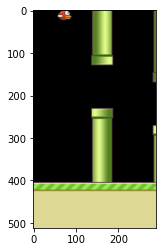

In [ ]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(image.transpose([1, 0, 2]))
plt.show()
plt.close()

### Preprocessing the images

Alright, next we need to prepocess the images by converting them to grayscale and resizing them to $80\times 80$ pixels. This will help
to reduce the computation, and aid learning. Besides, Flappy is
"color blind." (Fun fact: The instructor of this course is also
[color vision deficient](https://en.wikipedia.org/wiki/Color_blindness).)


Shape of the transformed image: (288, 512, 3)


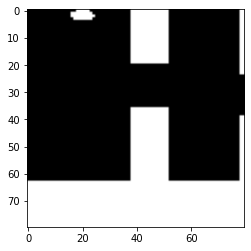

In [ ]:
def resize_gray(frame):
    frame = cv2.cvtColor(cv2.resize(frame, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, frame = cv2.threshold(frame, 1, 255, cv2.THRESH_BINARY)
    return np.reshape(frame, (80, 80, 1))

image_transformed = resize_gray(image)
print('Shape of the transformed image:', image.shape)

# show the transformed image
_ = plt.imshow(image_transformed.transpose((1, 0, 2)), cmap='gray')

This shows the preprocessed image for a single frame of
the game. In our implementation of Deep Q-Learning, we encode the state by stacking four consecutive frames, resulting in
a tensor of shape (80,80,4).

Then, given the `current_state`, and a raw image `image_raw`
of size $288\times512\times3$, we convert
the raw image to a $80\times80\times 1$ grayscale image using the
code in the previous cell. The ,
we remove the first frame of `current_state` and add
the new frame, giving again a stack of images of
size (80, 80, 4).

In [ ]:
def preprocess(image_raw, current_state=None):
    # resize and convert to grayscale
    image = resize_gray(image_raw)
    # stack the frames
    if current_state is None:
        state = np.concatenate((image, image, image, image), axis=2)
    else:
        state = np.concatenate((image, current_state[:, :, :3]), axis=2)
    return state

### 3.1 Explain the game state

Why is the state chosen to be a stack of four consecutive
frames rather than a single frame? Give an intuitive explanation.

[your answer here in Markdown]

###  Constructing the neural network

Now we are ready to construct the neural network for approximating the Q function. Recall that, given input $s$ which is of size $80\times80\times4$ due to the
previous preprocessing, the output of the network should be of size 2, corresponding to the values of $Q(s,a_1)$ and $Q(s, a_2)$ respectively.

Here is the summary of the model we'd like to build:

![Neural network](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn4/images/q_model.png)

### 3.2 Initialize the network

Complete the code in the next cell so that your model architecture matches that in the above picture. Here we specify the initialization of the weights by using `keras.initializers`.
Note that we haven't talked about the `strides` argument for CNNs;
you can read about stride here: [https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/). It's not important to understand this in detail, you just need to choose the number and sizes of the filters to get the shapes to match the specification.


In [ ]:
from tensorflow.keras import initializers
def create_q_model():
    state = layers.Input(shape=(80, 80, 4,))

    layer1 = layers.Conv2D(filters=..., kernel_size=..., strides=4, activation="relu",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(state)
    layer2 = layers.MaxPool2D(..., strides=2, padding="SAME")(layer1)
    layer3 = layers.Conv2D(filters=..., kernel_size=..., strides=2, activation="relu",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer2)
    layer4 = layers.Flatten()(layer3)
    q_value = layers.Dense(units=..., activation="linear",
                           kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                           bias_initializer=initializers.Constant(0.01))(layer4)

    return keras.Model(inputs=state, outputs=q_value)

Plot the model summary to make sure that the network is the same as expected.

In [ ]:
model = create_q_model()
print(model.summary())

### Deep Q-learning

We're now ready to implement the Q-learning algorithm.
There are some subtle details in the implementation that you need to sort out. First, recall that the update rule for Q learning is

$$Q(s,a) \leftarrow Q(s,a) + \alpha (r(s,a) + \gamma\cdot \max_{a'} Q(\text{next}(s,a), a') - Q(s,a))$$

where $\gamma$ is the discount factor and $\alpha$ can be viewed as the step size or learning rate for gradient ascent.

We'll set these as follows:

In [ ]:
gamma = 0.99            # decay rate of past observations
step_size = 1e-4        # step size

### Estimation with experience replay

At the beginning of training, we spend 10,000 steps taking random
actions, as a means of observing the environment.

We build a replay memory of length 10,000 steps, and every time we update the weights of the network, we sample a batch of size 32 and perform a Q-learning update on this batch.

After we have collected 10,000 steps of new data, we discard
the old data, and replace it with the new "experiences."


In [ ]:
observe = 10000            # timesteps to observe before training
replay_memory = 10000      # number of previous transitions to remember
batch_size = 32            # size of each batch


### 3.3 Justify the data collection

Why does it make sense to maintain the replay memory of a fixed size
instead of including all of the historical data?


[Your answer here in Markdown]

### Exploration vs exploitation

When performing Q-learning, we face the tradeoff between exploration and
exploitation.  To encourage exploration, a simple strategy is to take a random action at each step with certain probability.

More precisely, for each time step $t$ and state $s_t$, with probability $\epsilon$, the algorithm takes a random action (wing flap or do nothing), and with probability $1-\epsilon$ the
algorithm takes a greedy action according to $a_t = \arg\max_{a} Q_\theta(s_t,a)$. Here $\theta$ refers to the parameters of our CNN.

In [ ]:
# value of epsilon
epsilon = 0.05

### 3.4 Complete the Q-learning algorithm

Next you will need to complete the Q-learning algorithm by filling in the missing code in the following function.
The missing parts include

- Taking a greedy action
- Given a batch of samples $\{(s_t, a_t, r_t, s_{t+1}, \text{terminal}_t)\}_{t\in B}$, computing the corresponding $Q_\theta(s_t, a_t)$.
- Given a batch of samples $\{(s_t, a_t, r_t, s_{t+1}, \text{terminal}_t)\}_{t\in B}$, computing the corresponding updated Q-values
  
$$\hat{y}(s_t,a_t) = \begin{cases}
r_t + \gamma\, \max_{a} Q_\theta(s_{t+1}, a), & \text{if } \text{terminal}_t=0,\\
r_t, & \text{otherwise}.
\end{cases}$$

Then, the mean squared error loss for the batch is

$$\frac{1}{|B|} \sum_{t\in B} (\hat y(s_t, a_t) - Q_\theta(s_t, a_t))^2.$$



In [ ]:
def dql_flappy_bird(model, optimizer, loss_function):

    # initiate a game
    game = flappy_bird.GameState()

    # store the previous state, action and transitions
    history_data = deque()

    # get the first observation by doing nothing and preprocess the image
    do_nothing = np.zeros(num_actions)
    do_nothing[0] = 1
    image, reward, terminal = game.frame_step(do_nothing)

    # preprocess to get the state
    current_state = preprocess(image_raw=image)

    # training
    t = 0

    while t < 50000:
        if epsilon > np.random.rand(1)[0]:
            # random action
            action = np.random.choice(num_actions)
        else:
            # compute the Q function
            current_state_tensor = tf.convert_to_tensor(current_state)
            current_state_tensor = tf.expand_dims(current_state_tensor, 0)
            q_value = model(current_state_tensor, training=False)

            # greedy action
            #-----MISSING-----#
            # your code here
            #-----------------#

        # take the action and observe the reward and the next state
        action_vec = np.zeros([num_actions])
        action_vec[action] = 1
        image_raw, reward, terminal = game.frame_step(action_vec)
        next_state = preprocess(current_state=current_state,
                                image_raw=image_raw)

        # store the observation
        history_data.append((current_state, action, reward, next_state,
                            terminal))
        if len(history_data) > replay_memory:
            history_data.popleft()  # discard old data

        # train if done observing
        if t > observe:

            # sample a batch
            batch = random.sample(history_data, batch_size)
            state_sample = np.array([d[0] for d in batch])
            action_sample = np.array([d[1] for d in batch])
            reward_sample = np.array([d[2] for d in batch])
            state_next_sample = np.array([d[3] for d in batch])
            terminal_sample = np.array([d[4] for d in batch])

            # compute the updated Q-values for the samples
            #-----MISSING-----#
            # your code here
            #-----------------#

            # train the model on the states and updated Q-values
            with tf.GradientTape() as tape:
                # compute the current Q-values for the samples
                #-----MISSING-----#
                # your code here
                #-----------------#

                # compute the loss
                loss = loss_function(updated_q_value, current_q_value)

            # backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        else:
            loss = 0

        # update current state and counter
        current_state = next_state
        t += 1

        # print info every 500 steps
        if t % 500 == 0:
            print(f"STEP {t} | PHASE {'observe' if t<=observe else 'train'}",
                  f"| ACTION {action} | REWARD {reward} | LOSS {loss}")

You're now ready to play the game! Just run the cell below; do not change the code.

In [ ]:
def playgame(start_from_ckpt=False, ckpt_path=None):

    #! DO NOT change the random seed !
    np.random.seed(4)

    if start_from_ckpt:
        # if you want to start from a checkpoint
        model = keras.models.load_model('ckpt_path')
    else:
        model = create_q_model()

    # specify the optimizer and loss function
    optimizer = keras.optimizers.Adam(learning_rate=step_size, clipnorm=1.0)
    loss_function = keras.losses.MeanSquaredError()

    # play the game
    dql_flappy_bird(model=model, optimizer=optimizer, loss_function=loss_function)

In [ ]:
playgame()

### 3.5 Describe the training

Describe what you see by answering the following questions:

- In the early stage of training (within 2,000 steps in the *explore* phase),
  describe the behavior of the Flappy Bird. What do you think is the greedy policy
  given by the estimation of the Q-function in this stage?
- Describe what you see after roughly 5,000 training steps.
  Do you see any improvement?
  In particular, compare Flappy's behavior with their behavior in the early stages of
  training.
- Explain why the performance has improved, by relating to the model
  design such as the replay memory and the exploration.

[Your answer here in Markdown]

It takes a long time to fully train the network, so you're not required to
complete the training. Here's a [video](https://www.youtube.com/watch?v=THhUXIhjkCM) showing the performance of a well trained DQN.